<a href="https://colab.research.google.com/github/larixgomex/LH_AD_LARISSAGOMESDESANTANNA/blob/main/LH_AD_LARISSAGOMESDESANTANNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## **Introdução**

---


Este projeto propõe uma iniciativa de análise de dados e BI para o Banco Vitória (BanVic), uma instituição conhecida por sua eficiência em serviços bancários tanto físicos quanto digitais desde sua fundação em 2010, em São Paulo.

Para além da análise neste notebook, teremos ao final nossos dados limpos e organizados, de modo que estejam prontos a serem exibidos em nosso painel.

### Estrutura do Projeto

Este projeto foi dividido da seguinte forma:

Obtenção dos dados
- Bibliotecas
- Funções

Limpeza e pré-processamento de tabelas
- Dicionário de dados

Modelagem

Análise de Dados
- Perguntas de negócios e KPIs
  - Inauguração da Agência Digital
  - Análise da implementação do Pix


Dashboard

Considerações finais



### Obtenção dos Dados e Importação de Bibliotecas

Todos os dados utilizados foram obtidos a partir de arquivos ` .csv` disponibilizados pelo banco. Esta análise conta com sete tabelas, sendo cada uma pré processada de maneira individual. *Alguns blocos de código ao longo deste notebook foram ocultados para facilitar a leitura, entretanto estes podem ser verificados ao clicar "show code".*

In [ ]:
# @title Bibliotecas
# Bibliotecas padrão
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
# Configurar para não exibir warnings -> https://pypi.org/project/nb-black/
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
# adicionar anotações
from typing import Any
# adicionar tables
from tabulate import tabulate

In [ ]:
# @title Ficheiros a carregar
# Importação dos ficheiro .csv
df_agencias = pd.read_csv('agencias.csv')
df_clientes = pd.read_csv('clientes.csv')
df_colaborador_agencia = pd.read_csv('colaborador_agencia.csv')
df_colaboradores = pd.read_csv('colaboradores.csv')
df_contas = pd.read_csv('contas.csv')
df_propostas_credito = pd.read_csv('propostas_credito.csv')
df_transacoes = pd.read_csv('transacoes.csv')

### Funções

In [ ]:
# @title percentagem de valores nulos e seus respetivos dtypes
def table_review(df: pd.DataFrame) -> None:
    """
    Rever as percentagens de dados em falta em cada coluna de um DataFrame.
    Args:
    - df (pd.DataFrame): Input DataFrame a ser analisado.

    Returns:
    - None: Imprime um DataFrame que mostra os tipos de colunas, o número de valores nulos
      e a percentagem de dados em falta para cada coluna, ordenados por ordem descendente
      da percentagem de dados em falta.
    """
    # Calculate number of null values per column
    isnull = df.isnull().sum()

    # Get data types of columns
    type_columns = df.dtypes

    # Calculate percentage of missing data per column
    missing_percentage = round((isnull / len(df)) * 100, 2)

    # Create a DataFrame to display results
    review_df = pd.DataFrame({
        "Type": type_columns,
        "Isnull": isnull,
        "Missing data %": missing_percentage
    })

    # Print the DataFrame sorted by missing data percentage in descending order
    print(review_df.sort_values(by="Missing data %", ascending=False))

In [ ]:
# @title processar datetime com formatos mistos e retornar como data
def process_datetime_mixed_column(df: pd.DataFrame, column_name: str) -> None:
    """
    Processar a coluna datetime num DataFrame para lidar com formatos datetime mistos.

    Args:
    - df (pd.DataFrame): Input DataFrame que contem a coluna datetime.
    - column_name (str): Nome da coluna datetime a ser processada.

    Returns:
    - None: Modifica o DataFrame no local, convertendo a coluna especificada para datetime64 dtype.
    """
    # Remove 'UTC' suffix from column
    df[column_name] = df[column_name].astype(str).str.replace(' UTC', '')

    # Parse column to datetime with mixed format inference
    df[column_name] = pd.to_datetime(df[column_name], format='mixed')

    # Criar nova coluna para a hora
    df[f'{column_name}_hora'] = df[column_name].dt.time

    # Convert column to date dtype
    df[column_name] = df[column_name].dt.date



In [ ]:
# @title formatar cep no formato 'XXXXX-XXX'
def reformatar_cep(df: pd.DataFrame, nome_coluna: str = 'cep') -> pd.DataFrame:
    """
    Reformatar a coluna CEP em um DataFrame para o formato XXXXX-XXX.

    Parâmetros:
    df (pd.DataFrame): O DataFrame contendo a coluna CEP.
    nome_coluna (str): O nome da coluna a ser reformatada. O padrão é 'cep'.

    Retorna:
    pd.DataFrame: O DataFrame com a coluna CEP reformatada.
    """
    # Garantir que a coluna 'cep' é uma string
    df[nome_coluna] = df[nome_coluna].astype(str)

    # Reformatar valores 'cep' para o formato 'XXXXX-XXX' apenas se não estiverem no formato correto
    df[nome_coluna] = df[nome_coluna].apply(lambda x: x if '-' in x else f"{x[:5]}-{x[5:]}")

    return df.head()

In [ ]:
# @title formatar cpf no formato 'XXX.XXX.XXX-XX'
def reformatar_cpf(df: pd.DataFrame, nome_coluna: str = 'cpf') -> pd.DataFrame:
    """
    Reformatar a coluna CPF em um DataFrame para o formato XXX.XXX.XXX-XX.

    Parâmetros:
    df (pd.DataFrame): O DataFrame contendo a coluna CPF.
    nome_coluna (str): O nome da coluna a ser reformatada. O padrão é 'cpf'.

    Retorna:
    pd.DataFrame: O DataFrame com a coluna CPF reformatada.
    """
    # Garantir que a coluna 'cpf' é uma string
    df[nome_coluna] = df[nome_coluna].astype(str)

    # Preencher valores 'cpf' com zeros à esquerda, se necessário, para garantir que tenham 11 caracteres
    df[nome_coluna] = df[nome_coluna].str.zfill(11)

    # formatar valores 'cpf' para o formato 'XXX.XXX.XXX-XX' apenas se não estiverem no formato correto
    df[nome_coluna] = df[nome_coluna].apply(lambda x: x if '.' in x and '-' in x else f"{x[:3]}.{x[3:6]}.{x[6:9]}-{x[9:]}")

    return df.head()

In [ ]:
# @title contar valores unicos
from typing import Any, Union

def count_unique_values(df: pd.DataFrame, column: Union[str, Any]) -> int:
    """
    Determina a quantidade de valores únicos em uma coluna de um DataFrame.

    Parâmetros:
    df (pd.DataFrame): O DataFrame a ser analisado.
    column (str): O nome da coluna para a qual se deseja contar os valores únicos.

    Retorna:
    int: O número de valores únicos na coluna especificada.
    """
    if column not in df.columns:
        raise ValueError(f"A coluna '{column}' não existe no DataFrame fornecido.")

    unique_values_count = df[column].nunique()
    return unique_values_count

# **Limpeza e pré-processamento das tabelas fornecidas**

## Agências

### **Quantidade de atributos (variáveis) e de entradas do conjunto de dados**

Antes de começar qualquer análise, é preciso examinar a estrutura do dataset. Portanto, serão avaliadas as 5 primeiras entradas:

In [ ]:
# Volume de dados do DataFrame
print(f'Entradas no DataFrame: {df_agencias.shape[0]} linhas no total')
print(f'Variáveis no DataFrame: {df_agencias.shape[1]} colunas no total')

# Verificando as primeiras entradas
display(df_agencias.head())

Entradas no DataFrame: 10 linhas no total
Variáveis no DataFrame: 7 colunas no total


,cod_agencia,nome,endereco,cidade,uf,data_abertura,tipo_agencia
0,7,Agência Digital,"Av. Paulista, 1436 - Cerqueira César, São Paul...",São Paulo,SP,2015-08-01,Digital
1,1,Agência Matriz,"Av. Paulista, 1436 - Cerqueira César, São Paul...",São Paulo,SP,2010-01-01,Física
2,2,Agência Tatuapé,"Praça Sílvio Romero, 158 - Tatuapé, São Paulo ...",São Paulo,SP,2010-06-14,Física
3,3,Agência Campinas,"Av. Francisco Glicério, 895 - Vila Lidia, Camp...",Campinas,SP,2012-03-04,Física
4,4,Agência Osasco,"Av. Antônio Carlos Costa, 1000 - Bela Vista, O...",Osasco,SP,2013-11-06,Física


#### **Tipos das variáveis**

Verificar os tipos de variáveis em um conjunto de dados é essencial para assegurar uma análise de dados precisa. Nesse contexto, é crucial conferir se os tipos são consistentes com as representações das variáveis.

In [ ]:
# Verificando o tipo das variáveis
df_agencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cod_agencia    10 non-null     int64 
 1   nome           10 non-null     object
 2   endereco       10 non-null     object
 3   cidade         10 non-null     object
 4   uf             10 non-null     object
 5   data_abertura  10 non-null     object
 6   tipo_agencia   10 non-null     object
dtypes: int64(1), object(6)
memory usage: 688.0+ bytes


### **Limpeza inicial**

In [ ]:
# Renomear colunas para legibilidade
df_agencias = df_agencias.rename(columns={
    'nome': 'nome_agencia',
    'endereco': 'endereco_agencia',
    'cidade': 'cidade_agencia',
    'uf': 'uf_agencia',
    'data_abertura': 'data_abertura_agencia'
})

In [ ]:
# garantir o formato de datas
df_agencias['data_abertura_agencia'] = pd.to_datetime(df_agencias.data_abertura_agencia)


#### **Porcentagem de valores ausentes no *dataset***



Pode-se verificar que esta tabela não possui valores ausentes.

In [ ]:
table_review(df_agencias)

                                 Type  Isnull  Missing data %
cod_agencia                     int64       0             0.0
nome_agencia                   object       0             0.0
endereco_agencia               object       0             0.0
cidade_agencia                 object       0             0.0
uf_agencia                     object       0             0.0
data_abertura_agencia  datetime64[ns]       0             0.0
tipo_agencia                   object       0             0.0


#### **Dicionário de Variáveis | agências**

- `cod_agencia`: Identificador único para cada agência/ chave primária (PK)
- `nome_agencia`: Nome da agência
- `endereco_agencia`: Endereço da agência
- `cidade_agencia`: Cidade onde a agência está localizada
- `uf_agencia`: Unidade Federativa (estado) onde a agência está localizada
- `data_abertura_agencia`: Data de abertura da agência
- `tipo_agencia`: Tipo da agência (por exemplo, física ou digital)


### **Insights iniciais**

In [ ]:
# Número de agências por estado
agencias_por_estado = df_agencias['uf_agencia'].value_counts()
print("Número de agências por estado:")
print(agencias_por_estado)

# Número de agências por cidade
agencias_por_cidade = df_agencias['cidade_agencia'].value_counts()
print("\nNúmero de agências por cidade:")
print(agencias_por_cidade)

# Agência mais antiga e mais nova
agencia_mais_antiga = df_agencias.loc[df_agencias['data_abertura_agencia'].idxmin()]
agencia_mais_nova = df_agencias.loc[df_agencias['data_abertura_agencia'].idxmax()]

print("\nAgência mais antiga:")
print(agencia_mais_antiga)
print("\nAgência mais nova:")
print(agencia_mais_nova)

# Distribuição por tipo de agência
tipo_agencia_dist = df_agencias['tipo_agencia'].value_counts()
print("\nDistribuição por tipo de agência:")
print(tipo_agencia_dist)

# Análise de abertura de agências ao longo dos anos
df_agencias['ano_abertura_agencia'] = df_agencias['data_abertura_agencia'].dt.year
agencias_por_ano = df_agencias['ano_abertura_agencia'].value_counts().sort_index()
print("\nNúmero de agências abertas por ano:")
print(agencias_por_ano)

Número de agências por estado:
uf_agencia
SP    6
RS    1
RJ    1
SC    1
PE    1
Name: count, dtype: int64

Número de agências por cidade:
cidade_agencia
São Paulo         4
Campinas          1
Osasco            1
Porto Alegre      1
Rio de Janeiro    1
Florianópolis     1
Recife            1
Name: count, dtype: int64

Agência mais antiga:
cod_agencia                                                              1
nome_agencia                                                Agência Matriz
endereco_agencia         Av. Paulista, 1436 - Cerqueira César, São Paul...
cidade_agencia                                                   São Paulo
uf_agencia                                                              SP
data_abertura_agencia                                  2010-01-01 00:00:00
tipo_agencia                                                        Física
Name: 1, dtype: object

Agência mais nova:
cod_agencia                                                             10
nome_agencia  

#### **Exportar para .csv**

In [ ]:
# Exporte este dataframe para .csv
df_agencias.to_csv('dim_agencias.csv', index=False)



---



## Clientes

### **Quantidade de atributos (variáveis) e de entradas do conjunto de dados**

In [ ]:
# volume de dados do DataFrame
print(f'Entradas no DataFrame: {df_clientes.shape[0]} linhas no total')
print(f'Variáveis no DataFrame: {df_clientes.shape[1]} colunas no total')

# verificando as primeiras entradas
display(df_clientes.head())

Entradas no DataFrame: 998 linhas no total
Variáveis no DataFrame: 10 colunas no total


,cod_cliente,primeiro_nome,ultimo_nome,email,tipo_cliente,data_inclusao,cpfcnpj,data_nascimento,endereco,cep
0,28,Sabrina,Dias,moreiraemanuelly@example.org,PF,2017-04-03 16:11:00 UTC,357.081.496-39,2006-08-11,Praia de Duarte Vila Piratininga 81327-166 Fer...,95140-704
1,674,Luiz Felipe,Dias,pedroferreira@example.org,PF,2021-02-10 13:27:00 UTC,085.196.374-93,1995-10-11,"Avenida da Rosa, 654 João Paulo Ii 20295449 Nu...",76516-765
2,693,Renan,Dias,ogomes@example.net,PF,2020-01-21 13:12:00 UTC,783.416.059-10,1948-11-19,Jardim de Rodrigues Ipiranga 14161-477 Duarte ...,51779625
3,743,Clara,Dias,rafaelcorreia@example.org,PF,2019-05-06 11:39:00 UTC,589.237.610-95,1978-01-27,"Colônia Thomas Silva, 9 Tupi B 15771-946 Ferna...",19615792
4,769,André,Dias,danilo33@example.org,PF,2017-01-07 14:53:00 UTC,459.608.721-02,1990-08-25,"Rua Correia, 889 Diamante 59123250 Aragão / RS",01672838


#### **Tipos das variáveis**

In [ ]:
# verificar o tipo das variáveis
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cod_cliente      998 non-null    int64 
 1   primeiro_nome    998 non-null    object
 2   ultimo_nome      998 non-null    object
 3   email            998 non-null    object
 4   tipo_cliente     998 non-null    object
 5   data_inclusao    998 non-null    object
 6   cpfcnpj          998 non-null    object
 7   data_nascimento  998 non-null    object
 8   endereco         998 non-null    object
 9   cep              998 non-null    object
dtypes: int64(1), object(9)
memory usage: 78.1+ KB


### **Limpeza inicial**

In [ ]:
# renomear colunas
df_clientes = df_clientes.rename(columns={
    'email': 'email_cliente',
    'data_inclusao': 'data_inclusao_cliente',
    'cpfcnpj': 'cpf_cnpj',
    'data_nascimento': 'data_nascimento_cliente',
    'endereco': 'endereco_cliente',
    'cep': 'cep_cliente'
})
# concatenar as colunas 'primeiro_nome' e 'ultimo_nome' em uma nova coluna chamada nome_cliente
df_clientes['nome_cliente'] = df_clientes['primeiro_nome'] + ' ' + df_clientes['ultimo_nome']
# Criar a coluna uf extraindo os dois últimos caracteres da coluna endereco
df_clientes['uf_cliente'] = df_clientes['endereco_cliente'].str[-2:]

# calcular a idade dos clientes
ano_atual = 2024
df_clientes['idade_cliente'] = ano_atual - pd.to_datetime(df_clientes['data_nascimento_cliente']).dt.year

# garantir que 'data_inclusao_cliente' esta em datetime format
df_clientes['data_inclusao_cliente'] = pd.to_datetime(df_clientes['data_inclusao_cliente'])

# calcular o tempo decorrido como cliente
df_clientes['tempo_cliente'] = ano_atual - df_clientes['data_inclusao_cliente'].dt.year


In [ ]:
# padronizar numeros de cpf e codigo postal
reformatar_cep(df_clientes, 'cep_cliente')
reformatar_cpf(df_clientes, 'cpf_cnpj')

process_datetime_mixed_column(df_clientes, 'data_inclusao_cliente')

In [ ]:
table_review(df_clientes)

                              Type  Isnull  Missing data %
cod_cliente                  int64       0             0.0
primeiro_nome               object       0             0.0
ultimo_nome                 object       0             0.0
email_cliente               object       0             0.0
tipo_cliente                object       0             0.0
data_inclusao_cliente       object       0             0.0
cpf_cnpj                    object       0             0.0
data_nascimento_cliente     object       0             0.0
endereco_cliente            object       0             0.0
cep_cliente                 object       0             0.0
nome_cliente                object       0             0.0
uf_cliente                  object       0             0.0
idade_cliente                int32       0             0.0
tempo_cliente                int32       0             0.0
data_inclusao_cliente_hora  object       0             0.0


In [ ]:
df_clientes.head()

,cod_cliente,primeiro_nome,ultimo_nome,email_cliente,tipo_cliente,data_inclusao_cliente,cpf_cnpj,data_nascimento_cliente,endereco_cliente,cep_cliente,nome_cliente,uf_cliente,idade_cliente,tempo_cliente,data_inclusao_cliente_hora
0,28,Sabrina,Dias,moreiraemanuelly@example.org,PF,2017-04-03,357.081.496-39,2006-08-11,Praia de Duarte Vila Piratininga 81327-166 Fer...,95140-704,Sabrina Dias,SP,18,7,16:11:00
1,674,Luiz Felipe,Dias,pedroferreira@example.org,PF,2021-02-10,085.196.374-93,1995-10-11,"Avenida da Rosa, 654 João Paulo Ii 20295449 Nu...",76516-765,Luiz Felipe Dias,AP,29,3,13:27:00
2,693,Renan,Dias,ogomes@example.net,PF,2020-01-21,783.416.059-10,1948-11-19,Jardim de Rodrigues Ipiranga 14161-477 Duarte ...,51779-625,Renan Dias,RN,76,4,13:12:00
3,743,Clara,Dias,rafaelcorreia@example.org,PF,2019-05-06,589.237.610-95,1978-01-27,"Colônia Thomas Silva, 9 Tupi B 15771-946 Ferna...",19615-792,Clara Dias,SP,46,5,11:39:00
4,769,André,Dias,danilo33@example.org,PF,2017-01-07,459.608.721-02,1990-08-25,"Rua Correia, 889 Diamante 59123250 Aragão / RS",01672-838,André Dias,RS,34,7,14:53:00


#### **Dicionário de Variáveis | clientes**

- `cod_cliente`: Identificador único para cada cliente cadastrado / chave primária (PK)
- `primeiro_nome`: Primeiro nome do cliente
- `ultimo_nome`: Último nome do cliente
- `email_cliente`: Endereço de email do cliente
- `tipo_cliente`: Tipo de cliente (Pessoa Física ou Pessoa Jurídica)
- `data_inclusao_cliente`: Data em que se tornou cliente
- `cpf_cnpj`: Número do CPF (para Pessoa Física) ou CNPJ (para Pessoa Jurídica) do cliente
- `data_nascimento_cliente`: Data de nascimento do cliente
- `endereco_cliente`: Endereço residencial ou comercial do cliente
- `cep_cliente`: Código de Endereçamento Postal (CEP) do cliente
- `nome_cliente`: Nome completo do cliente
- `uf_cliente`: Estado (representado por uf) do cliente
- `idade_cliente`: Idade calculada a partir do ano atual
- `tempo_cliente`: Tempo decorrido desde a data de inclusão
- `data_inclusao_cliente_hora`: Corresponde à hora extraída da data de inclusão


#### **Exportar para .csv**

In [ ]:
# Exporte este dataframe para .csv
df_clientes.to_csv('dim_clientes.csv', index=False)



---



## Colaborador x Agência

### Quantidade de atributos (variáveis) e de entradas do conjunto de dados

In [ ]:
# Volume de dados do DataFrame
print(f'Entradas no DataFrame: {df_colaborador_agencia.shape[0]} linhas no total')
print(f'Variáveis no DataFrame: {df_colaborador_agencia.shape[1]} colunas no total')

# Verificando as primeiras entradas
display(df_colaborador_agencia.head())

Entradas no DataFrame: 100 linhas no total
Variáveis no DataFrame: 2 colunas no total


,cod_colaborador,cod_agencia
0,7,1
1,13,1
2,14,1
3,23,1
4,24,1


#### Tipos das variáveis

In [ ]:
# verificar o tipo das variáveis
df_colaborador_agencia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   cod_colaborador  100 non-null    int64
 1   cod_agencia      100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB


#### **Porcentagem de valores ausentes no *dataset***


In [ ]:
table_review(df_colaborador_agencia)

                  Type  Isnull  Missing data %
cod_colaborador  int64       0             0.0
cod_agencia      int64       0             0.0


### **Dicionário de Variáveis | colaborador_agencia**

- `cod_colaborador`: Identificador único para cada colaborador, chave primária (PK)
- `cod_agencia`: Identificador único para cada agência, chave estrangeira (FK)


#### **Exportar para .csv**

In [ ]:
# Exporte este dataframe para .csv
df_colaborador_agencia.to_csv('dim_colaboradores_agencia.csv', index=False)



---



## Colaboradores

### Quantidade de atributos (variáveis) e de entradas do conjunto de dados

In [ ]:
# Volume de dados do DataFrame
print(f'Entradas no DataFrame: {df_colaboradores.shape[0]} linhas no total')
print(f'Variáveis no DataFrame: {df_colaboradores.shape[1]} colunas no total')

# Verificando as primeiras entradas
display(df_colaboradores.head())

Entradas no DataFrame: 100 linhas no total
Variáveis no DataFrame: 8 colunas no total


,cod_colaborador,primeiro_nome,ultimo_nome,email,cpf,data_nascimento,endereco,cep
0,14,Paulo,Dias,melissalopes@example.net,847.210.695-02,1974-04-24,"Lagoa de Rodrigues, 62 Zilah Sposito 37328-273...",27275674
1,19,Luiz Fernando,Dias,pcunha@example.net,820.415.963-33,1994-07-10,"Ladeira de Moreira, 82 Jardim Atlântico 27617-...",50013962
2,32,Vitor Hugo,Dias,aragaonicolas@example.net,936.172.548-37,1986-12-18,Área Sophie Moreira Maria Virgínia 71941-111 S...,08955-215
3,88,João Gabriel,Lima,luiz-otaviorezende@example.org,967.082.451-67,1994-10-19,"Trevo Murilo Ramos, 92 São Benedito 73615-597 ...",24224-305
4,39,Maria Eduarda,Melo,joao-pedro72@example.com,857.496.210-49,1996-03-01,"Parque de Moura, 65 Granja Werneck 67769059 da...",96896390


#### Tipos das variáveis

In [ ]:
# verificar o tipo das variáveis
df_colaboradores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cod_colaborador  100 non-null    int64 
 1   primeiro_nome    100 non-null    object
 2   ultimo_nome      100 non-null    object
 3   email            100 non-null    object
 4   cpf              100 non-null    object
 5   data_nascimento  100 non-null    object
 6   endereco         100 non-null    object
 7   cep              100 non-null    object
dtypes: int64(1), object(7)
memory usage: 6.4+ KB


### **Limpeza inicial**

In [ ]:
# Renomear colunas
df_colaboradores = df_colaboradores.rename(columns={
    'primeiro_nome': 'primeiro_nome_colaborador',
    'ultimo_nome': 'ultimo_nome_colaborador',
    'email': 'email_colaborador',
    'cpf': 'cpf_colaborador',
    'endereco': 'endereco_colaborador',
    'cep': 'cep_colaborador'
})

# Concatenar 'primeiro_nome' e 'ultimo_nome' em 'nome_colaborador'
df_colaboradores['nome_colaborador'] = df_colaboradores['primeiro_nome_colaborador'] + ' ' + df_colaboradores['ultimo_nome_colaborador']


In [ ]:
# converter para o formato date
df_colaboradores.data_nascimento =pd.to_datetime( df_colaboradores.data_nascimento)

#### **Porcentagem de valores ausentes no *dataset***


In [ ]:
table_review(df_colaboradores)

                                     Type  Isnull  Missing data %
cod_colaborador                     int64       0             0.0
primeiro_nome_colaborador          object       0             0.0
ultimo_nome_colaborador            object       0             0.0
email_colaborador                  object       0             0.0
cpf_colaborador                    object       0             0.0
data_nascimento            datetime64[ns]       0             0.0
endereco_colaborador               object       0             0.0
cep_colaborador                    object       0             0.0
nome_colaborador                   object       0             0.0


### **Dicionário de Variáveis | colaboradores**

- `cod_colaborador`: Identificador único para cada colaborador
- `primeiro_nome_colaborador`: Primeiro nome do colaborador
- `ultimo_nome_colaborador`: Último nome do colaborador
- `email_colaborador`: Endereço de email do colaborador
- `cpf_colaborador`: CPF do colaborador
- `data_nascimento`: Data de nascimento do colaborador
- `endereco_colaborador`: Endereço residencial do colaborador
- `cep_colaborador`: Código de Endereçamento Postal (CEP) do colaborador
- `nome_colaborador`: Nome completo do colaborador

#### **Exportar para .csv**

In [ ]:
# Exporte este dataframe para .csv
df_colaboradores.to_csv('dim_colaboradores.csv', index=False)



---



## Contas

### Quantidade de atributos (variáveis) e de entradas do conjunto de dados

In [ ]:
# volume de dados do DataFrame
print(f'Entradas no DataFrame: {df_contas.shape[0]} linhas no total')
print(f'Variáveis no DataFrame: {df_contas.shape[1]} colunas no total')

# verificar as primeiras entradas
display(df_contas.head())

Entradas no DataFrame: 999 linhas no total
Variáveis no DataFrame: 9 colunas no total


,num_conta,cod_cliente,cod_agencia,cod_colaborador,tipo_conta,data_abertura,saldo_total,saldo_disponivel,data_ultimo_lancamento
0,53,53,1,7,PF,2011-05-24 15:30:00 UTC,2984.7615,2814.67,2019-07-02 11:03:46 UTC
1,190,190,1,7,PF,2014-10-17 14:48:00 UTC,4262.4322,4191.86,2021-03-25 12:00:15 UTC
2,191,191,1,7,PF,2013-03-23 14:14:00 UTC,3266.5680,3080.71,2016-09-09 23:34:15 UTC
3,203,203,1,7,PF,2016-08-03 16:13:00 UTC,21241.5424,19461.56,2022-12-28 07:58:24 UTC
4,254,254,1,7,PF,2012-10-24 13:48:00 UTC,13335.6966,13197.54,2013-12-20 22:20:00 UTC


#### Tipos das variáveis

In [ ]:
# verificar o tipo das variáveis
df_contas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   num_conta               999 non-null    int64  
 1   cod_cliente             999 non-null    int64  
 2   cod_agencia             999 non-null    int64  
 3   cod_colaborador         999 non-null    int64  
 4   tipo_conta              999 non-null    object 
 5   data_abertura           999 non-null    object 
 6   saldo_total             999 non-null    float64
 7   saldo_disponivel        999 non-null    float64
 8   data_ultimo_lancamento  999 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 70.4+ KB


### **Limpeza inicial**


In [ ]:
# renomear colunas
df_contas = df_contas.rename(columns={
    'data_abertura': 'data_abertura_conta'
})

In [ ]:
process_datetime_mixed_column(df_contas, 'data_abertura_conta')
process_datetime_mixed_column(df_contas, 'data_ultimo_lancamento')

#### **Porcentagem de valores ausentes no *dataset***


In [ ]:
table_review(df_contas)

                                Type  Isnull  Missing data %
num_conta                      int64       0             0.0
cod_cliente                    int64       0             0.0
cod_agencia                    int64       0             0.0
cod_colaborador                int64       0             0.0
tipo_conta                    object       0             0.0
data_abertura_conta           object       0             0.0
saldo_total                  float64       0             0.0
saldo_disponivel             float64       0             0.0
data_ultimo_lancamento        object       0             0.0
data_abertura_conta_hora      object       0             0.0
data_ultimo_lancamento_hora   object       0             0.0


In [ ]:
df_contas.head()

,num_conta,cod_cliente,cod_agencia,cod_colaborador,tipo_conta,data_abertura_conta,saldo_total,saldo_disponivel,data_ultimo_lancamento,data_abertura_conta_hora,data_ultimo_lancamento_hora
0,53,53,1,7,PF,2011-05-24,2984.7615,2814.67,2019-07-02,15:30:00,11:03:46
1,190,190,1,7,PF,2014-10-17,4262.4322,4191.86,2021-03-25,14:48:00,12:00:15
2,191,191,1,7,PF,2013-03-23,3266.5680,3080.71,2016-09-09,14:14:00,23:34:15
3,203,203,1,7,PF,2016-08-03,21241.5424,19461.56,2022-12-28,16:13:00,07:58:24
4,254,254,1,7,PF,2012-10-24,13335.6966,13197.54,2013-12-20,13:48:00,22:20:00


Há apenas clientes cadastrados como Pesso Física.

#### **Dicionário de Variáveis | contas**

- `num_conta`: Identificador único para cada conta
- `cod_cliente`: Identificador único para cada cliente cadastrado
- `cod_agencia`: Identificador único para cada agência
- `cod_colaborador`: Identificador único para cada colaborador
- `tipo_conta`: Tipo da conta (por exemplo, corrente, poupança)
- `data_abertura`: Data de abertura da conta
- `saldo_total`: Saldo de utilização livre cuja movimentação não está sujeita a juros ou outros encargos.
- `saldo_disponivel`:Diferença entre os movimentos a crédito e a débito efetuados na conta.
- `data_ultimo_lancamento`: Data do mais recente lançamento
-`data_abertura_hora`: Horário extraído da coluna data_abertura (UTC)
-`data_ultimo_lancamento_hora`:Horário extraído da coluna data_ultimo_lancamento (UTC)


#### **Exportar para .csv**

In [ ]:
# Exporte este dataframe para .csv
df_contas.to_csv('dim_contas.csv', index=False)



---



## Propostas de Crédito

### Quantidade de atributos (variáveis) e de entradas do conjunto de dados

In [ ]:
# Volume de dados do DataFrame
print(f'Entradas no DataFrame: {df_propostas_credito.shape[0]} linhas no total')
print(f'Variáveis no DataFrame: {df_propostas_credito.shape[1]} colunas no total')

# Verificando as primeiras entradas
display(df_propostas_credito.head())

Entradas no DataFrame: 2000 linhas no total
Variáveis no DataFrame: 12 colunas no total


,cod_proposta,cod_cliente,cod_colaborador,data_entrada_proposta,taxa_juros_mensal,valor_proposta,valor_financiamento,valor_entrada,valor_prestacao,quantidade_parcelas,carencia,status_proposta
0,116,338,1,2014-05-30 18:43:12 UTC,0.0194,36199.950355,50032.03,13832.079645,1045.219825,58,0,Enviada
1,715,45,1,2021-06-17 13:09:32 UTC,0.0131,12897.538285,19848.55,6951.011715,232.124685,100,1,Enviada
2,755,494,1,2021-08-10 04:24:02 UTC,0.0203,122236.312551,187154.36,64918.047449,3673.518951,56,0,Enviada
3,953,381,1,2011-02-23 07:57:58 UTC,0.0167,47784.649757,59530.61,11745.960243,955.041560,109,3,Enviada
4,1046,176,1,2010-11-15 16:03:28 UTC,0.0211,178393.038243,214294.19,35901.151757,10219.659415,22,4,Enviada


#### Tipos das variáveis

In [ ]:
# Verificando o tipo das variáveis
df_propostas_credito.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cod_proposta           2000 non-null   int64  
 1   cod_cliente            2000 non-null   int64  
 2   cod_colaborador        2000 non-null   int64  
 3   data_entrada_proposta  2000 non-null   object 
 4   taxa_juros_mensal      2000 non-null   float64
 5   valor_proposta         2000 non-null   float64
 6   valor_financiamento    2000 non-null   float64
 7   valor_entrada          2000 non-null   float64
 8   valor_prestacao        2000 non-null   float64
 9   quantidade_parcelas    2000 non-null   int64  
 10  carencia               2000 non-null   int64  
 11  status_proposta        2000 non-null   object 
dtypes: float64(5), int64(5), object(2)
memory usage: 187.6+ KB


### **Limpeza inicial**


In [ ]:
process_datetime_mixed_column(df_propostas_credito, 'data_entrada_proposta')

#### **Porcentagem de valores ausentes no *dataset***


In [ ]:
table_review(df_propostas_credito)

                               Type  Isnull  Missing data %
cod_proposta                  int64       0             0.0
cod_cliente                   int64       0             0.0
cod_colaborador               int64       0             0.0
data_entrada_proposta        object       0             0.0
taxa_juros_mensal           float64       0             0.0
valor_proposta              float64       0             0.0
valor_financiamento         float64       0             0.0
valor_entrada               float64       0             0.0
valor_prestacao             float64       0             0.0
quantidade_parcelas           int64       0             0.0
carencia                      int64       0             0.0
status_proposta              object       0             0.0
data_entrada_proposta_hora   object       0             0.0


In [ ]:
df_propostas_credito.head()

,cod_proposta,cod_cliente,cod_colaborador,data_entrada_proposta,taxa_juros_mensal,valor_proposta,valor_financiamento,valor_entrada,valor_prestacao,quantidade_parcelas,carencia,status_proposta,data_entrada_proposta_hora
0,116,338,1,2014-05-30,0.0194,36199.950355,50032.03,13832.079645,1045.219825,58,0,Enviada,18:43:12
1,715,45,1,2021-06-17,0.0131,12897.538285,19848.55,6951.011715,232.124685,100,1,Enviada,13:09:32
2,755,494,1,2021-08-10,0.0203,122236.312551,187154.36,64918.047449,3673.518951,56,0,Enviada,04:24:02
3,953,381,1,2011-02-23,0.0167,47784.649757,59530.61,11745.960243,955.041560,109,3,Enviada,07:57:58
4,1046,176,1,2010-11-15,0.0211,178393.038243,214294.19,35901.151757,10219.659415,22,4,Enviada,16:03:28


#### **Dicionário de Variáveis | propostas_credito**

- `cod_proposta`: Identificador único para cada proposta de crédito
- `cod_cliente`: Identificador único para cada cliente cadastrado
- `cod_colaborador`: Identificador único para cada colaborador
- `data_entrada_proposta`: Data de entrada da proposta de crédito
- `taxa_juros_mensal`: Taxa de juros mensal da proposta de crédito
- `valor_proposta`: Valor total da proposta de crédito
- `valor_financiamento`: Valor do financiamento solicitado
- `valor_entrada`: Valor de entrada pago pelo cliente
- `valor_prestacao`: Valor de cada prestação
- `quantidade_parcelas`: Número total de parcelas
- `carencia`: Período de carência para o início do pagamento
- `status_proposta`: Status atual da proposta de crédito
- `data_entrada_proposta_hora`: Horário em que a proposta foi submetida (extraído de data_entrada_proposta)

#### **Exportar para .csv**

In [ ]:
# Exporte este dataframe para .csv
df_propostas_credito.to_csv('fact_propostas.csv', index=False)

## Transações

### Quantidade de atributos (variáveis) e de entradas do conjunto de dados

In [ ]:
# volume de dados do DataFrame
print(f'Entradas no DataFrame: {df_transacoes.shape[0]} linhas no total')
print(f'Variáveis no DataFrame: {df_transacoes.shape[1]} colunas no total')

# verificar as primeiras entradas
display(df_transacoes.head())

Entradas no DataFrame: 37091 linhas no total
Variáveis no DataFrame: 5 colunas no total


,cod_transacao,num_conta,data_transacao,nome_transacao,valor_transacao
0,3100,256,2020-05-22 03:15:21 UTC,Saque,-130.0
1,28405,256,2021-06-29 11:52:38 UTC,Saque,-255.0
2,1776,512,2020-05-17 13:04:50 UTC,Saque,-250.0
3,14311,512,2020-09-06 02:55:34 UTC,Saque,-80.0
4,25012,512,2020-10-16 09:26:52 UTC,Saque,-475.0


#### Tipos das variáveis

In [ ]:
# verificar o tipo das variáveis
df_transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37091 entries, 0 to 37090
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cod_transacao    37091 non-null  int64  
 1   num_conta        37091 non-null  int64  
 2   data_transacao   37091 non-null  object 
 3   nome_transacao   37090 non-null  object 
 4   valor_transacao  37090 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.4+ MB


### **Limpeza inicial**


In [ ]:
process_datetime_mixed_column(df_transacoes, 'data_transacao')

#### **Porcentagem de valores ausentes no *dataset***


In [ ]:
table_review(df_transacoes)

                        Type  Isnull  Missing data %
cod_transacao          int64       0             0.0
num_conta              int64       0             0.0
data_transacao        object       0             0.0
nome_transacao        object       1             0.0
valor_transacao      float64       1             0.0
data_transacao_hora   object       0             0.0


In [ ]:
df_transacoes.head()

,cod_transacao,num_conta,data_transacao,nome_transacao,valor_transacao,data_transacao_hora
0,3100,256,2020-05-22,Saque,-130.0,03:15:21
1,28405,256,2021-06-29,Saque,-255.0,11:52:38
2,1776,512,2020-05-17,Saque,-250.0,13:04:50
3,14311,512,2020-09-06,Saque,-80.0,02:55:34
4,25012,512,2020-10-16,Saque,-475.0,09:26:52


#### **Dicionário de Variáveis | transacoes**

- `cod_transacao`: Identificador único para cada transação
- `num_conta`: Identificador único para cada conta
- `data_transacao`: Data da transação
- `nome_transacao`: Nome ou descrição da transação
- `valor_transacao`: Valor da transação
- `data_transacao_hora`: Horário em que a transação occorreu (extraído de data_transacao)


#### **Exportar para .csv**

In [ ]:
# Exporte este dataframe para .csv
df_transacoes.to_csv('fact_transacoes.csv', index=False)



---



---

# **Modelagem de Dados e Indicadores de Negócios**

---


Atualmente, a modelagem de dados do BanVic segue um formato tradicional baseado no modelo entidade-relacionamento (ER), onde cada entidade como clientes, contas, transações e agências é representada em tabelas separadas. Essa abordagem, embora adequada para registrar operações diárias e transações simples, apresenta limitações na capacidade de realizar análises complexas e extrair ideias estratégicas.

Com a implementação de um **data warehouse (DWH)**, a estrutura de modelagem de dados do BanVic pode ser redefinida para priorizar análises avançadas.

Neste exemplo, as **tabelas facto** foram introduzidas para armazenar métricas críticas de negócio, como transações financeiras e propostas de crédito, enquanto as **tabelas dimensões**, como clientes, agências e datas, proporcionam contexto para essas métricas. Essa separação facilita a extração de insights valiosos, fundamentais para o desenvolvimento de iniciativas de negócios mais assertivas.


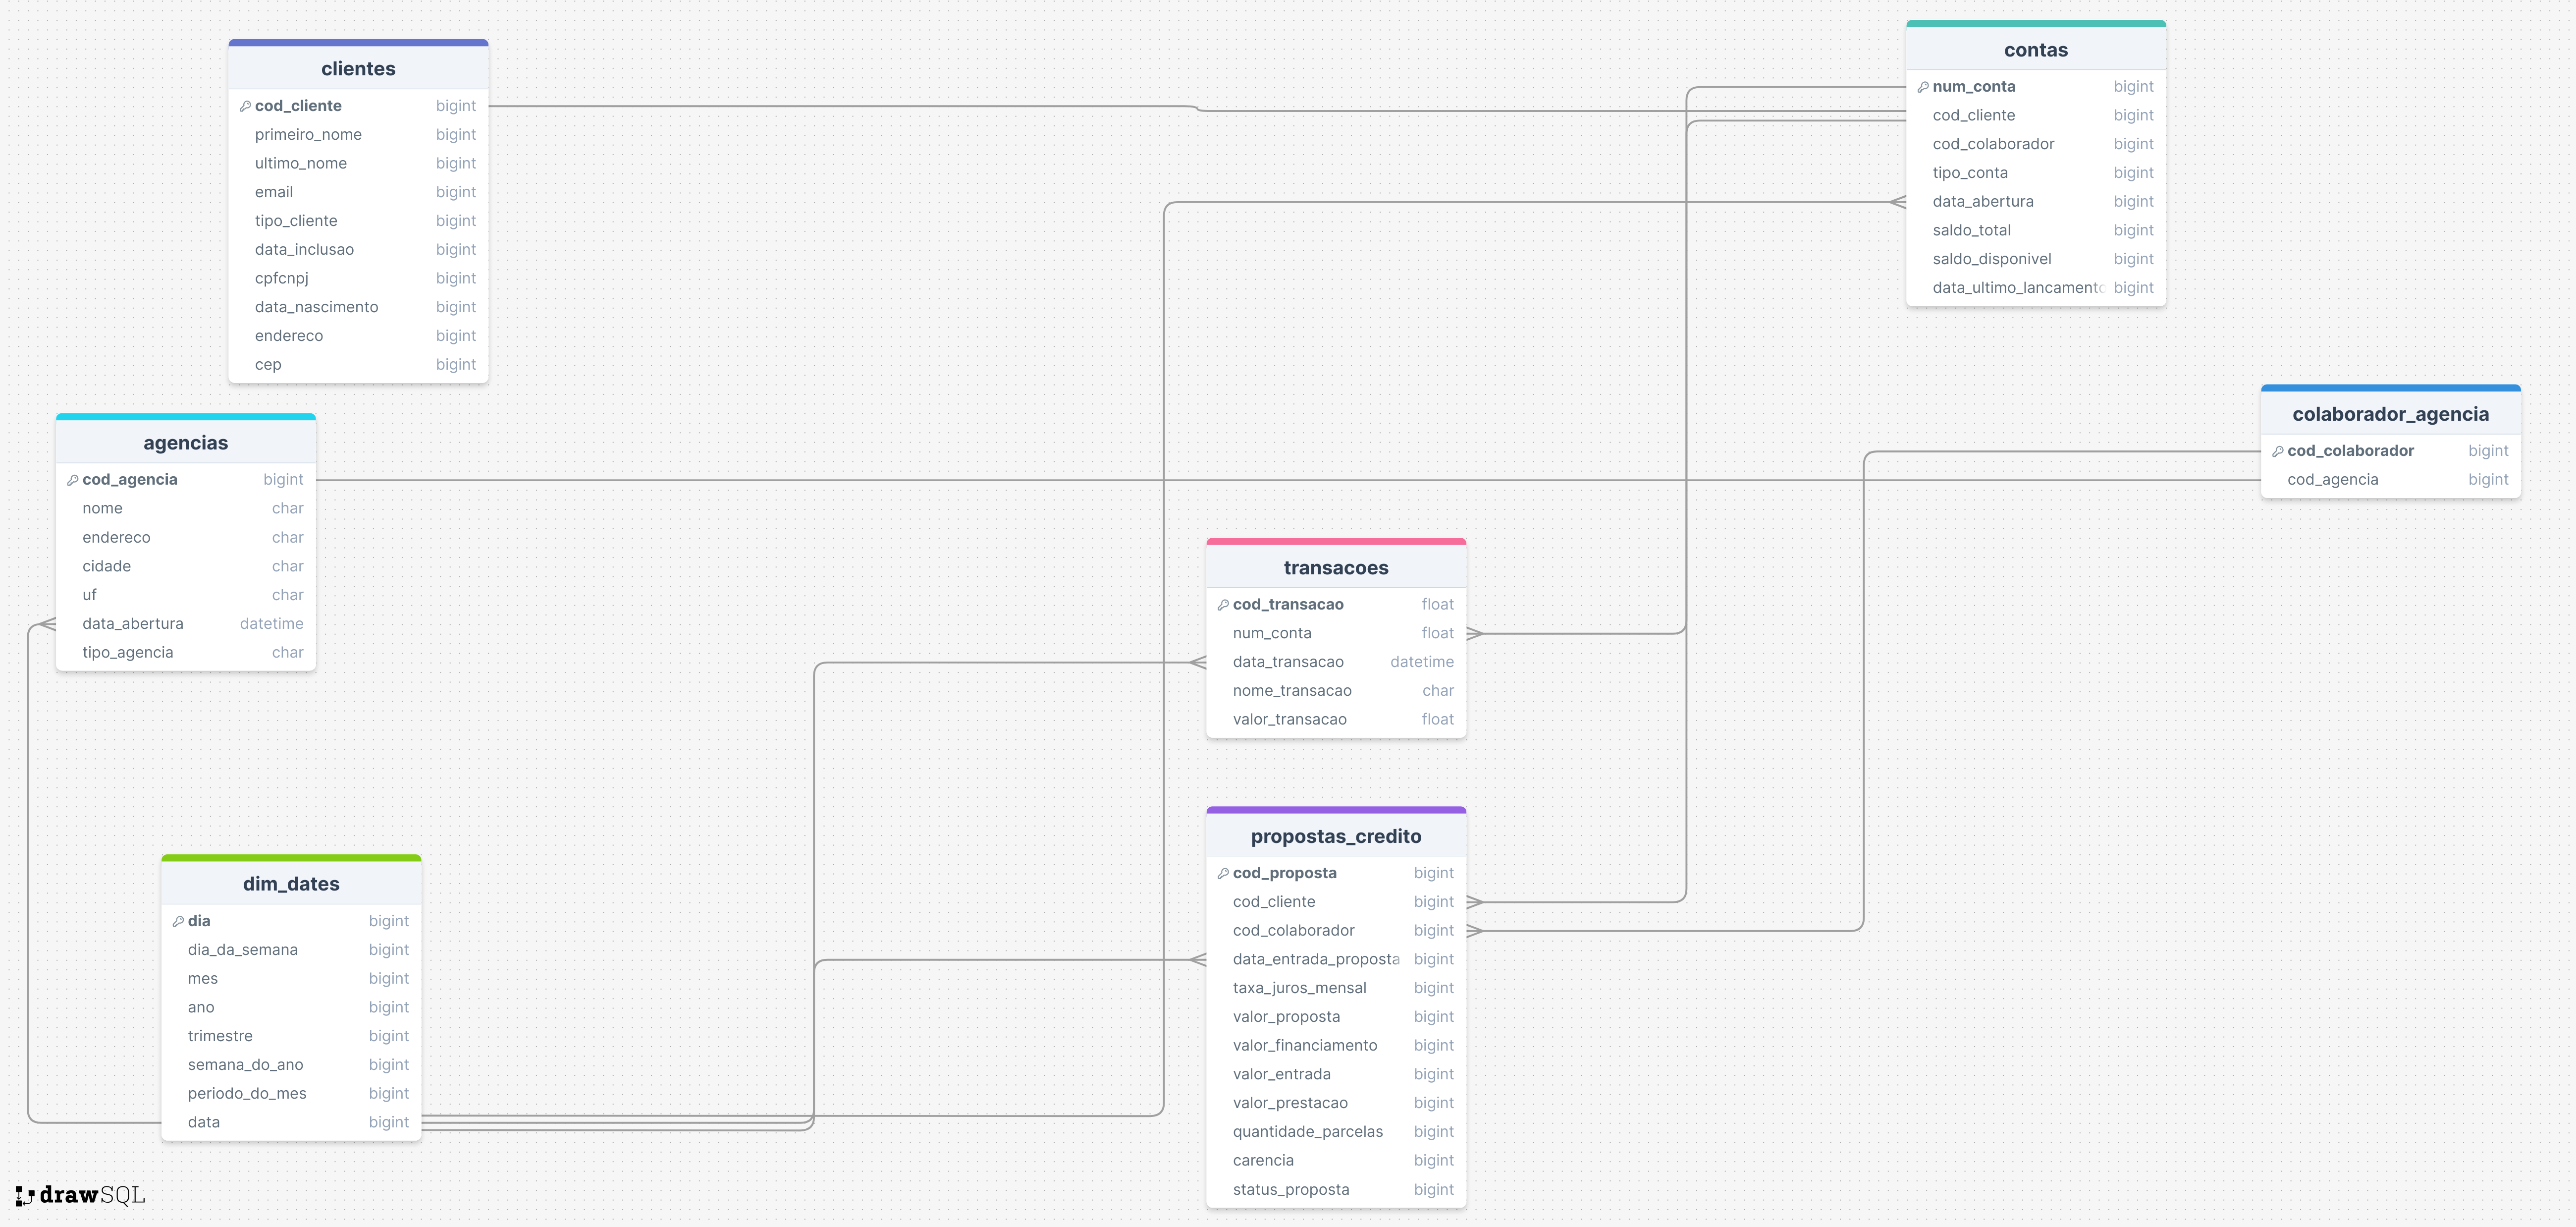

In [ ]:
# @title Tabela dim_dates

# Definir o intervalo de datas desejado
start_date = '2010-01-01'
end_date = '2023-12-31'

# Gerar um range de datas diárias
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Criar o dataframe dim_dates
dim_dates = pd.DataFrame(dates, columns=['data_data'])

# Converter a coluna 'data' para datetime, se necessário
dim_dates['data_data'] = pd.to_datetime(dim_dates['data_data'])

# Adicionar outras colunas de interesse
dim_dates['dia'] = dim_dates['data_data'].dt.day
dia_da_semana_map = {
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

# Adicionar coluna com os dias da semana em português
dim_dates['dia_da_semana'] = dim_dates['data_data'].dt.strftime('%A').map(dia_da_semana_map)
dim_dates['mes'] = dim_dates['data_data'].dt.month
dim_dates['ano'] = dim_dates['data_data'].dt.year
dim_dates['trimestre'] = dim_dates['data_data'].dt.quarter.map(lambda x: f'Q{x}')
dim_dates['semana_do_ano'] = dim_dates['data_data'].dt.isocalendar().week

# Adicionar uma coluna para identificar o período do mês
dim_dates['periodo_mes'] = pd.cut(dim_dates['data_data'].dt.day,
                                  bins=[0, 15, 31],
                                  labels=['inicio_mes', 'fim_mes'])
# Exibir o dataframe com a nova coluna
print(dim_dates.tail())  # Exibindo as cinco últimas linhas para visualizar melhor


      data_data  dia dia_da_semana  mes   ano trimestre  semana_do_ano  \
5108 2023-12-27   27  Quarta-feira   12  2023        Q4             52   
5109 2023-12-28   28  Quinta-feira   12  2023        Q4             52   
5110 2023-12-29   29   Sexta-feira   12  2023        Q4             52   
5111 2023-12-30   30        Sábado   12  2023        Q4             52   
5112 2023-12-31   31       Domingo   12  2023        Q4             52   

     periodo_mes  
5108     fim_mes  
5109     fim_mes  
5110     fim_mes  
5111     fim_mes  
5112     fim_mes  


#### **Exportar para .csv**

In [ ]:
# Exporte este dataframe para .csv
dim_dates.to_csv('dim_dates.csv', index=False)

### **Mesclagem das tabelas**

In [ ]:
# renomear os DataFrames já limpos para seguir a convenção
# dim tables
dim_clientes = df_clientes
dim_agencias = df_agencias
dim_colaboradores = df_colaboradores
dim_colaboradores_agencia = df_colaborador_agencia
dim_contas = df_contas

# fact tables
fact_transacoes = df_transacoes
fact_propostas = df_propostas_credito

In [ ]:
# dim_contas
# Left join df_contas com dim_clientes usando cod_cliente
dim_contas = df_contas.merge(dim_clientes, on='cod_cliente', how='left')

# Left join do resultado anterior com dim_agencias usando cod_agencia
dim_contas = dim_contas.merge(dim_agencias, on='cod_agencia', how='left')

# Left join do resultado anterior com dim_colaboradores usando cod_colaborador
dim_contas = dim_contas.merge(dim_colaboradores, on='cod_colaborador', how='left')

# dim_colaboradores
# Left join entre dim_colaboradores_agencia e dim_agencias usando cod_agencia
dim_colaborador_agencia = dim_colaboradores_agencia.merge(dim_agencias, on='cod_agencia', how='left')

# Left join do resultado anterior com dim_colaboradores usando cod_colaborador
dim_colaborador_agencia = dim_colaborador_agencia.merge(dim_colaboradores, on='cod_colaborador', how='left')

# Mesclar fact_transacoes e dim_contas
fact_transacoes = fact_transacoes.merge(dim_contas, on='num_conta', how='left')

# Left join entre fact_propostas e dim_agencias usando cod_colaborador
fact_propostas = fact_propostas.merge(dim_colaborador_agencia, on='cod_colaborador', how='left')


In [74]:
# Exporte este dataframe para .csv
fact_transacoes.to_csv('fact_transacoes_clean.csv', index=False)
fact_propostas.to_csv('fact_propostas_clean.csv', index=False)

---

# **Análise de Dados**

---


### **KPIs e Perguntas de Negócios**

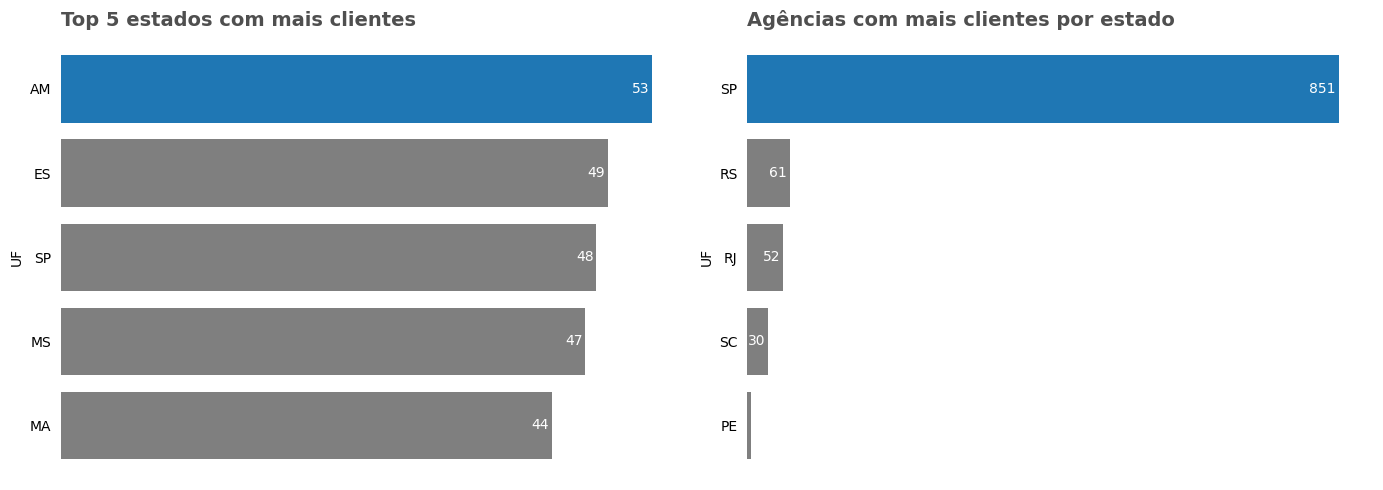

In [ ]:
# @title **1.Qual estado tem mais clientes no total e qual estado tem a agência com mais clientes?**
# Calcular o número de clientes por UF e pegar as 5 UFs com mais clientes, ordenadas decrescentemente
clientes_por_uf = dim_clientes['uf_cliente'].value_counts().sort_values(ascending=False).head(5)


# Calcular o número de clientes por UF das agências, ordenadas decrescentemente
clientes_por_uf_agencias = dim_contas['uf_agencia'].value_counts().sort_values(ascending=False)

# Configurações de estilo do gráfico
cinza = '#7f7f7f'
cinza2 = '#4f4f4f'
azul = '#1f77b4'

# Formação do gráfico
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Gráfico de barras para número de clientes por UF (limitar às 5 principais e ordenadas decrescentemente)
clientes_por_uf.sort_values().plot.barh(color=cinza, width=0.8, ax=ax1)
ax1.set_title('Top 5 estados com mais clientes', loc='left', fontsize=14, color=cinza2, fontweight='bold')
ax1.set_ylabel('UF')
ax1.set_xlabel('Número de Clientes')
# Adicionar rótulos de dados
for rect in ax1.patches:
    width = rect.get_width()
    ax1.annotate(f'{width}', xy=(rect.get_x() + rect.get_width(),
                                 rect.get_y() + rect.get_height() / 2),
                 xytext=(-2, -5),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 color='white')

# Destacar barra de valor máximo em azul
max_value = clientes_por_uf.max()
for i, (value, name) in enumerate(zip(clientes_por_uf.sort_values(ascending=True).values, clientes_por_uf.sort_values(ascending=True).index)):
    ax1.text(value, i, f' {value} ',  ha='left', color='white')
    if value == max_value:
        ax1.patches[i].set_facecolor(azul)

# Remover grids e eixos
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Remover yticks do eixo y
ax1.tick_params(left=False)

# Remover eixo x
ax1.get_xaxis().set_visible(False)

# Gráfico de barras para número de clientes por UF das agências (ordenadas decrescentemente)
clientes_por_uf_agencias.sort_values().plot.barh(color=cinza, width=0.8, ax=ax2)
ax2.set_title('Agências com mais clientes por estado', loc='left', fontsize=14, color=cinza2, fontweight='bold')
ax2.set_ylabel('UF')
ax2.set_xlabel('Número de Clientes')

# Adicionar rótulos de dados
for rect in ax2.patches:
    width = rect.get_width()
    ax2.annotate(f'{width}', xy=(rect.get_x() + rect.get_width(),
                                 rect.get_y() + rect.get_height() / 2),
                 xytext=(-2, 0),
                 textcoords='offset points',
                 ha='right',
                 va='center',
                 color='white')

# Destacar barra de valor máximo em azul
max_value_agencias = clientes_por_uf_agencias.max()
for i, (value, name) in enumerate(zip(clientes_por_uf_agencias.sort_values(ascending=True).values, clientes_por_uf_agencias.sort_values(ascending=True).index)):
    ax2.text(value, i, f' {value} ',  ha='left', color='white')
    if value == max_value_agencias:
        ax2.patches[i].set_facecolor(azul)

# Remover grids e eixos
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Remover yticks do eixo y
ax2.tick_params(left=False)

# Remover eixo x
ax2.get_xaxis().set_visible(False)

# Ajustar espaçamento entre os subplots
plt.tight_layout()

# Exibir o gráfico
plt.show()


- O Amazonas é o estado com mais clientes, apesar disso não temos uma agência no local.

- As agências de São Paulo são as que mais possuem clientes. Nesse caso, é possível que parte dessas pessoas estejam amparadas pela agência digital.

In [ ]:
# Filtrar dim_contas para UF do cliente igual a 'AM'
dim_contas_am = dim_contas[dim_contas['uf_cliente'] == 'AM']

# Agrupar por nome_agencia e contar o número de clientes
clientes_por_agencia_am = dim_contas_am.groupby('nome_agencia')['cod_cliente'].count().reset_index()

# Renomear a coluna de contagem para algo mais descritivo
clientes_por_agencia_am.columns = ['nome_agencia', 'num_clientes_AM']

# Exibir o resultado
print(clientes_por_agencia_am)

            nome_agencia  num_clientes_AM
0       Agência Campinas                6
1        Agência Digital               25
2  Agência Florianópolis                1
3         Agência Matriz                8
4         Agência Osasco                3
5   Agência Porto Alegre                2
6         Agência Recife                1
7        Agência Tatuapé                7


Verifica-se então que os clientes do estado do Amazonas estão de fato majoritariamente sob a agência digital, que tecnicamente pertence ao estado de São Paulo.

Ainda assim, temos clientes daquele estado nas mais diversas agências espalhadas pelo país. É possível tanto que não tenham sua morada atualizada quanto que essa informação seja de fato exata.

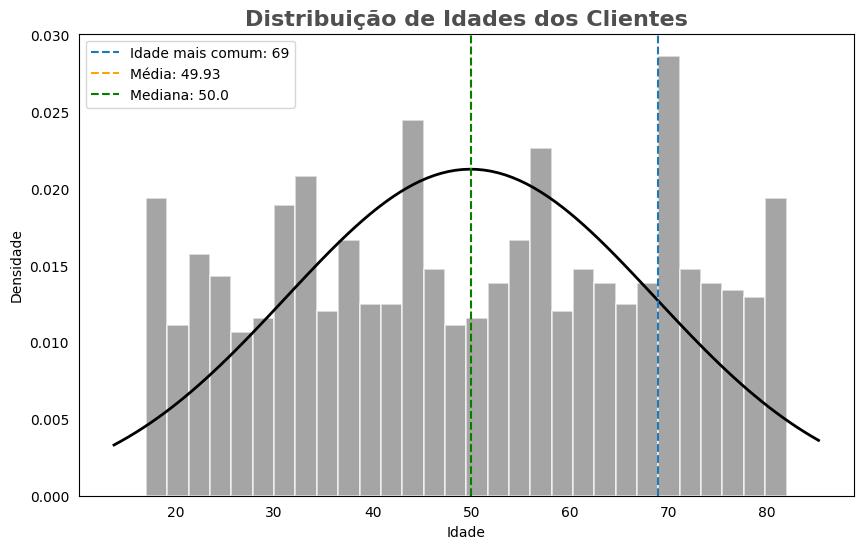

In [ ]:
# @title **2. Qual a idade mais comum entre nossos clientes?**
from scipy.stats import norm

# Calcular a idade mais comum
idade_mais_comum = dim_clientes['idade_cliente'].mode()[0]

# Configurações de estilo do gráfico
cinza = '#7f7f7f'
cinza2 = '#4f4f4f'
azul = '#1f77b4'

# Plotar o gráfico de distribuição de idades com curva de distribuição normal
plt.figure(figsize=(10, 6))
plt.hist(dim_clientes['idade_cliente'], bins=30, density=True, color=cinza, edgecolor='white', linewidth=1.2, alpha=0.7)

# Ajustar a distribuição normal
mu, std = norm.fit(dim_clientes['idade_cliente'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Destacar a barra da idade mais comum em azul
plt.axvline(idade_mais_comum, color=azul, linestyle='dashed', linewidth=1.5, label=f'Idade mais comum: {idade_mais_comum}')

# Adicionar rótulo para a média e mediana
plt.axvline(dim_clientes['idade_cliente'].mean(), color='orange', linestyle='dashed', linewidth=1.5, label=f'Média: {dim_clientes["idade_cliente"].mean():.2f}')
plt.axvline(dim_clientes['idade_cliente'].median(), color='green', linestyle='dashed', linewidth=1.5, label=f'Mediana: {dim_clientes["idade_cliente"].median()}')

plt.title('Distribuição de Idades dos Clientes', fontsize=16, color=cinza2, fontweight='bold')
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.legend()

# Remover grids e eixos
plt.grid(False)
plt.tick_params(left=False, bottom=False)

# Exibir o gráfico
plt.show()

A presença de uma moda relativamente alta em 69 anos indica que há um grupo de clientes significativo nessa faixa etária.

A mediana de 50 anos sugere que a distribuição das idades é razoavelmente simétrica, com uma quantidade aproximadamente igual de clientes abaixo e acima dessa idade.

A média próxima à mediana indica que a distribuição pode ser aproximadamente simétrica e não fortemente influenciada por outliers.

Essas inferências ajudam a compreender a distribuição das idades dos clientes de forma mais completa, destacando tanto as tendências centrais quanto as áreas de concentração de dados.

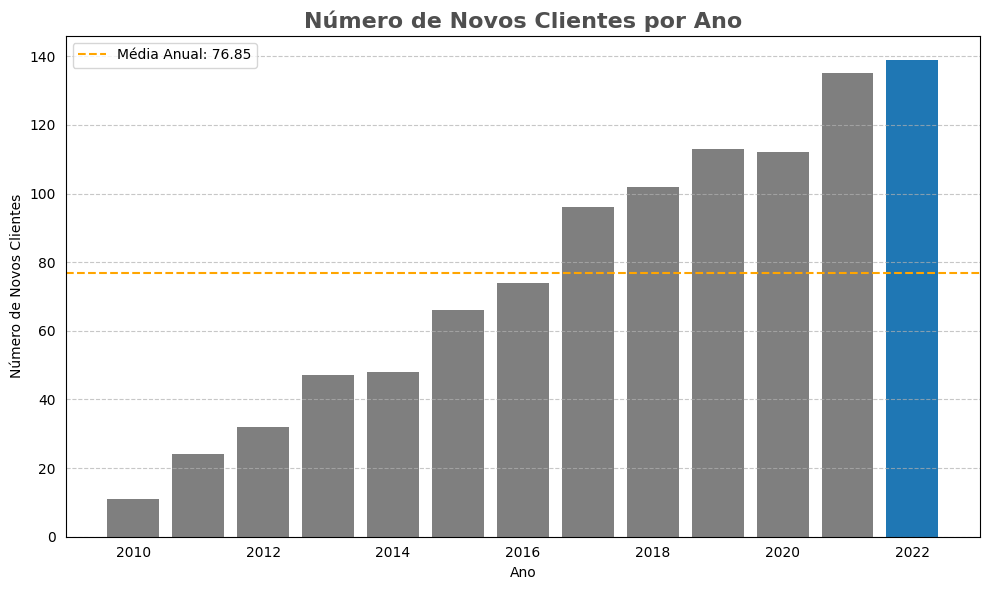

Média anual de novos clientes: 76.85


In [ ]:
# @title **3. Qual a média anual de novos clientes?**
# Contar o número de novos clientes por ano
dim_contas['ano_abertura_conta'] = pd.to_datetime(dim_contas['data_abertura_conta']).dt.year
clientes_por_ano = dim_contas['ano_abertura_conta'].value_counts().reset_index()
clientes_por_ano.columns = ['ano', 'num_novos_clientes']
clientes_por_ano = clientes_por_ano.sort_values(by='ano')  # Ordenar por ano
media_anual_novos_clientes = clientes_por_ano['num_novos_clientes'].mean()

# Configurações de estilo do gráfico
cinza = '#7f7f7f'
cinza2 = '#4f4f4f'
azul = '#1f77b4'

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))

# Plotar todas as barras em cinza
plt.bar(clientes_por_ano['ano'], clientes_por_ano['num_novos_clientes'], color=cinza)

# Encontrar o ano com o máximo de novos clientes
ano_max = clientes_por_ano.loc[clientes_por_ano['num_novos_clientes'].idxmax(), 'ano']

# Plotar a barra do ano com o máximo de novos clientes em azul
plt.bar(ano_max, clientes_por_ano.loc[clientes_por_ano['ano'] == ano_max, 'num_novos_clientes'], color=azul, width=0.8)

plt.title('Número de Novos Clientes por Ano', fontsize=16, color=cinza2, fontweight='bold')
plt.xlabel('Ano')
plt.ylabel('Número de Novos Clientes')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar média anual como linha pontilhada
plt.axhline(y=media_anual_novos_clientes, color='orange', linestyle='--', linewidth=1.5, label=f'Média Anual: {media_anual_novos_clientes:.2f}')
plt.legend()

# Remover grids e eixos
plt.tick_params(left=False, bottom=False)
plt.grid(False, axis='x')

# Exibir o gráfico
plt.tight_layout()
plt.show()

print(f"Média anual de novos clientes: {media_anual_novos_clientes:.2f}")


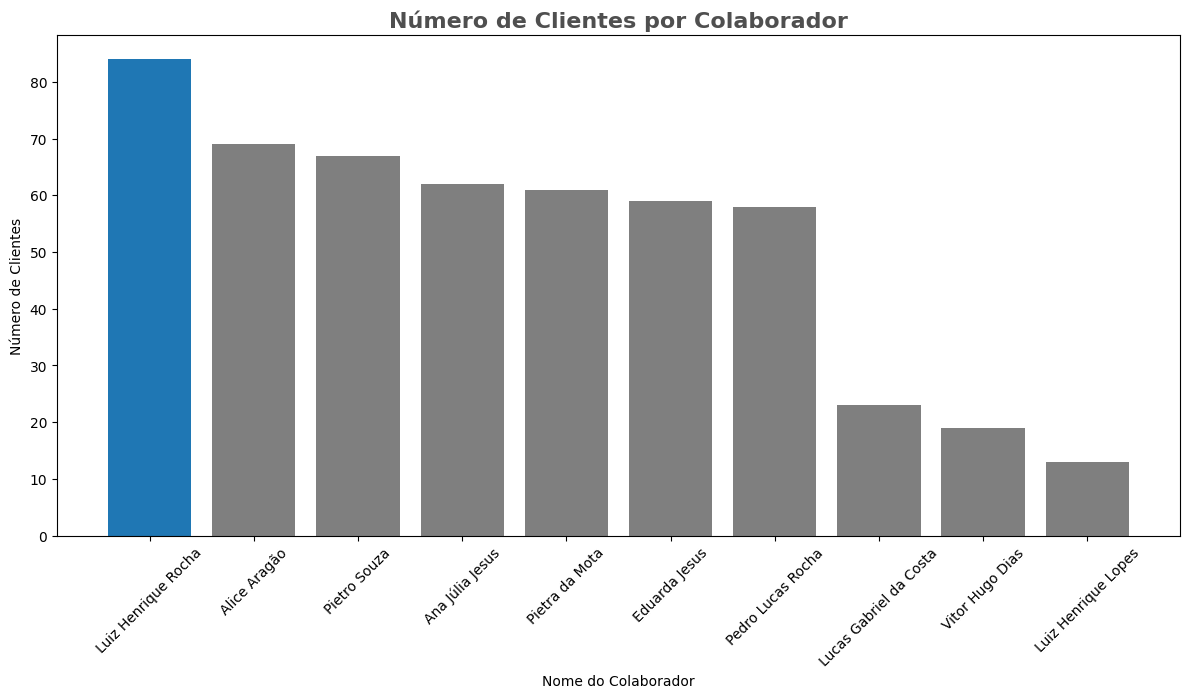

In [ ]:
# @title **4. Quais os colaboradores com mais clientes?**
# Contar o número de clientes por colaborador
clientes_por_colaborador = dim_contas['cod_colaborador'].value_counts().reset_index()
clientes_por_colaborador.columns = ['cod_colaborador', 'num_clientes']
top_10_colaboradores = clientes_por_colaborador.head(10)

# Join com dim_colaboradores para obter nomes completos
top_10_colaboradores = top_10_colaboradores.merge(dim_colaboradores, on='cod_colaborador')

# Configurações de estilo do gráfico
cinza = '#7f7f7f'
cinza2 = '#4f4f4f'
azul = '#1f77b4'

# Plotar o gráfico de barras
plt.figure(figsize=(12, 6))

# Plotar todas as barras em cinza
plt.bar(top_10_colaboradores['nome_colaborador'], top_10_colaboradores['num_clientes'], color=cinza)

# Título e rótulos dos eixos
plt.title('Número de Clientes por Colaborador', fontsize=16, color=cinza2, fontweight='bold')
plt.xlabel('Nome do Colaborador')
plt.ylabel('Número de Clientes')

# Destacar a barra do colaborador com mais clientes em azul
max_value_colaborador = top_10_colaboradores['num_clientes'].max()
for i, num_clientes in enumerate(top_10_colaboradores['num_clientes']):
    if num_clientes == max_value_colaborador:
        plt.bar(top_10_colaboradores.loc[i, 'nome_colaborador'], num_clientes, color=azul, width=0.8)
    else:
        plt.bar(top_10_colaboradores.loc[i, 'nome_colaborador'], num_clientes, color=cinza)

# Exibir o gráfico
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Essa é uma métrica interessante de ser explorada para o bem-estar dos funcionários. É importante considerar a possibilidade de sobrecarga como um fator que afeta a performance.

Além disso, podemos avaliar a criação de novos programas de bonificação dos colaboradores. É claro que não podemos somente considerar a quantidade de clientes, mas também podemos criar um sistema de avaliações para adicionar uma métrica de qualidade (pontuação média fornecida pelos clientes, por exemplo) para manter nossos times bem dispostos e motivados.

In [ ]:
# @title **5. Com base nos saldos, quais colaboradores têm mais clientes no último quartil?**
# Calcular o ultimo quartil de saldo
ultimo_quartil = np.percentile(dim_contas['saldo_total'], 75)

# Filtrar colaboradores que têm clientes no ultimo quartil de saldo
colaboradores_ultimo_quartil = dim_colaboradores[dim_contas['saldo_total'] <= ultimo_quartil]['cod_colaborador'].unique()

# Contar clientes no ultimo quartil para cada colaborador e somar o saldo total
clientes_no_ultimo_quartil = dim_contas[dim_contas['cod_colaborador'].isin(colaboradores_ultimo_quartil)].groupby('cod_colaborador').agg(
    num_clientes_ultimo_quartil=('num_conta', 'count'),
    saldo_total_ultimo_quartil=('saldo_total', 'sum')
).reset_index()

# Ordenar e selecionar os top 3 colaboradores com mais clientes no primeiro quartil
top_3_colaboradores = clientes_no_ultimo_quartil.sort_values(by='num_clientes_ultimo_quartil', ascending=False).head(3)

# Adicionar nomes dos colaboradores a partir de dim_colaboradores
top_3_colaboradores = pd.merge(top_3_colaboradores, dim_colaboradores[['cod_colaborador', 'nome_colaborador']], on='cod_colaborador', how='left')

# Formatar o saldo_total_primeiro_quartil para reais BRL
top_3_colaboradores['saldo_total_ultimo_quartil'] = top_3_colaboradores['saldo_total_ultimo_quartil'].map('R${:,.2f}'.format)

# Exibir o resultado
print("Top 3 Colaboradores com Mais Clientes no último quartil de saldo:")
print(top_3_colaboradores)

Top 3 Colaboradores com Mais Clientes no último quartil de saldo:
   cod_colaborador  num_clientes_ultimo_quartil saldo_total_ultimo_quartil  \
0               20                           69             R$1,719,881.04   
1               84                           67             R$1,614,956.85   
2               86                           59             R$1,475,561.09   

  nome_colaborador  
0     Alice Aragão  
1     Pietro Souza  
2    Eduarda Jesus  


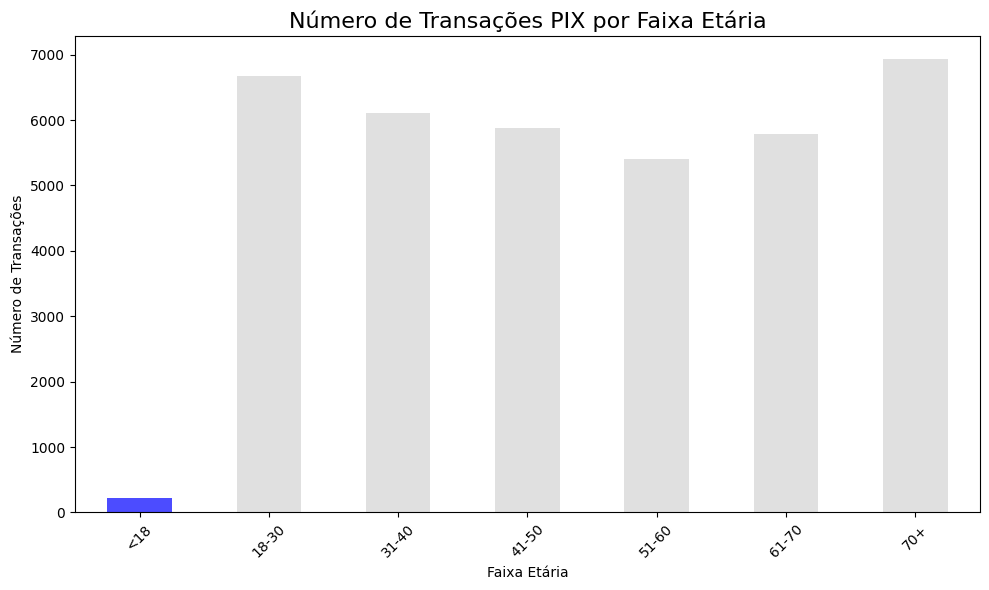

In [ ]:
# @title **6. Qual faixa etária é mais adepta ao Pix?**

# Calculando faixas etárias
bins = [0, 18, 30, 40, 50, 60, 70, 120]
labels = ['<18', '18-30', '31-40', '41-50', '51-60', '61-70', '70+']
fact_transacoes_pix = fact_transacoes
fact_transacoes_pix['faixa_etaria'] = pd.cut(fact_transacoes['idade_cliente'], bins=bins, labels=labels, right=False)
transacoes_por_faixa_etaria = fact_transacoes_pix['faixa_etaria'].value_counts().sort_index()


# Contando transações por faixa etária
transacoes_por_faixa_etaria = fact_transacoes_pix['faixa_etaria'].value_counts().sort_index()

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))

# Definindo cores para as barras
colors = ['blue' if x == transacoes_por_faixa_etaria.min() else 'lightgrey' for x in transacoes_por_faixa_etaria]

# Plotando as barras com as cores definidas
transacoes_por_faixa_etaria.plot(kind='bar', color=colors, alpha=0.7)

# Configurações do gráfico
plt.title('Número de Transações PIX por Faixa Etária', fontsize=16)
plt.xlabel('Faixa Etária')
plt.ylabel('Número de Transações')
plt.xticks(rotation=45)

# Remover grids
plt.gca().yaxis.grid(False)

plt.tight_layout()
plt.show()


### Análise da Implementação do PIX

In [ ]:
fact_transacoes.head()

,cod_transacao,num_conta,data_transacao,nome_transacao,valor_transacao,data_transacao_hora,cod_cliente,cod_agencia,cod_colaborador,tipo_conta,...,ano_abertura_agencia,primeiro_nome_colaborador,ultimo_nome_colaborador,email_colaborador,cpf_colaborador,data_nascimento,endereco_colaborador,cep_colaborador,nome_colaborador,faixa_etaria
0,3100,256,2020-05-22,Saque,-130.0,03:15:21,256,7,84,PF,...,2015,Pietro,Souza,diogo68@example.org,136.078.249-40,1985-03-31,"Sítio Pereira, 2 Baleia 52815-925 da Cruz / PB",92408-486,Pietro Souza,41-50
1,28405,256,2021-06-29,Saque,-255.0,11:52:38,256,7,84,PF,...,2015,Pietro,Souza,diogo68@example.org,136.078.249-40,1985-03-31,"Sítio Pereira, 2 Baleia 52815-925 da Cruz / PB",92408-486,Pietro Souza,41-50
2,1776,512,2020-05-17,Saque,-250.0,13:04:50,512,9,90,PF,...,2019,Cauê,Almeida,wcampos@example.org,176.084.239-78,1993-12-03,"Vale de Costa, 62 Acaiaca 71168-130 Gonçalves ...",61301741,Cauê Almeida,18-30
3,14311,512,2020-09-06,Saque,-80.0,02:55:34,512,9,90,PF,...,2019,Cauê,Almeida,wcampos@example.org,176.084.239-78,1993-12-03,"Vale de Costa, 62 Acaiaca 71168-130 Gonçalves ...",61301741,Cauê Almeida,18-30
4,25012,512,2020-10-16,Saque,-475.0,09:26:52,512,9,90,PF,...,2019,Cauê,Almeida,wcampos@example.org,176.084.239-78,1993-12-03,"Vale de Costa, 62 Acaiaca 71168-130 Gonçalves ...",61301741,Cauê Almeida,18-30


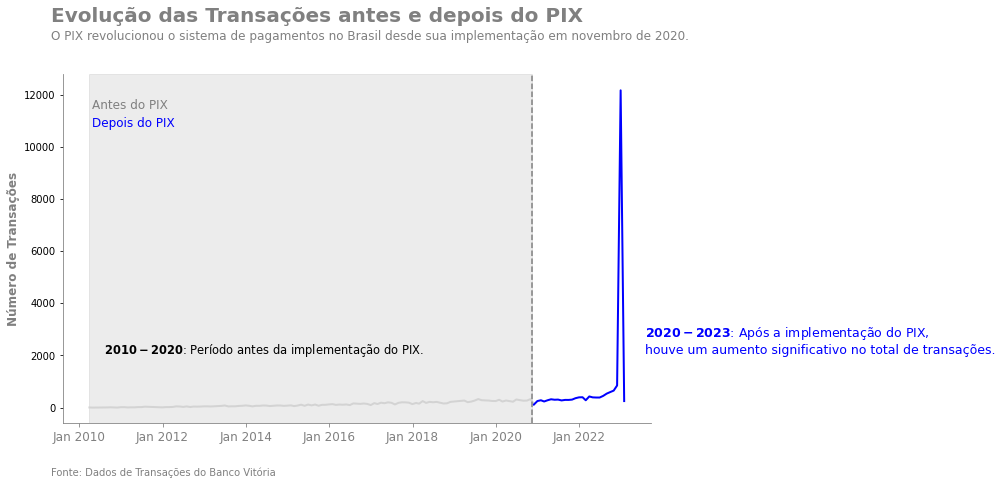

In [ ]:
# @title Gráfico: Transações antes e depois do Pix
import matplotlib.dates as mpl_dates


# Convertendo 'data_transacao' para datetime se necessário
fact_transacoes['data_transacao'] = pd.to_datetime(fact_transacoes['data_transacao'])

# Filtrar transações antes e depois do PIX
data_pix = pd.to_datetime('2020-11-16')
dados_antes_pix = fact_transacoes[fact_transacoes['data_transacao'] < data_pix]
dados_depois_pix = fact_transacoes[fact_transacoes['data_transacao'] >= data_pix]

# Agrupar por mês e contar o número único de cod_transacao
dados_antes_pix = dados_antes_pix.groupby(pd.Grouper(key='data_transacao', freq='M'))['cod_transacao'].nunique()
dados_depois_pix = dados_depois_pix.groupby(pd.Grouper(key='data_transacao', freq='M'))['cod_transacao'].nunique()

# Plotar o número total de transações mensais
fig, ax = plt.subplots(figsize=(14, 7), dpi=72)

# Gráfico de linha para cada segmento com cores diferentes
ax.plot(dados_antes_pix.index, dados_antes_pix.values, color='lightgrey', linewidth=2, label='Antes do PIX')
ax.plot(dados_depois_pix.index, dados_depois_pix.values, color='blue', linewidth=2, label='Depois do PIX')
# Definir área para foco (sombrar o período antes do PIX)
ax.axvspan(dados_antes_pix.index.min(), data_pix, color='grey', alpha=0.15)
# Remover grid
ax.grid(False)

# Remover linhas do eixo direito e superior
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Definir cores das linhas dos eixos x e y
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

# Configurar rótulos do eixo y
ax.set_ylabel('Número de Transações', color='grey', fontsize=12, fontweight='bold')

# Definir cor cinza dos valores do eixo x
ax.tick_params(axis='x', colors='grey', labelsize=12)

# Definir rótulos de mês no eixo x
ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %Y'))

# Título
ax.text(-0.02, 1.15, 'Evolução das Transações antes e depois do PIX', fontsize=20, color='grey', fontweight='bold', transform=ax.transAxes)

# Subtítulo
ax.text(-0.02, 1.10, 'O PIX revolucionou o sistema de pagamentos no Brasil desde sua implementação em novembro de 2020.', fontsize=12, color='grey', transform=ax.transAxes)

# Legendas
ax.text(0.05, 0.9, 'Antes do PIX', fontsize=12, color='grey', transform=ax.transAxes)
ax.text(0.05, 0.85, 'Depois do PIX', fontsize=12, color='blue', transform=ax.transAxes)
# Legendas
ax.text(0.07, 0.2, '$\\bf 2010-2020$: Período antes da implementação do PIX.',
        fontsize=11.5, color='black', transform=ax.transAxes)

ax.text(0.99, 0.2, '$\\bf 2020-2023$: Após a implementação do PIX,\n'
'houve um aumento significativo no total de transações.',
        fontsize=12.5, color='blue', transform=ax.transAxes)

# Adicionar linha vertical para a implementação do PIX
ax.axvline(data_pix, color='grey', linestyle='--')

# Rodapé para a fonte
ax.text(-0.02, -0.15, 'Fonte: Dados de Transações do Banco Vitória', fontsize=10, color='grey', transform=ax.transAxes)

# Ajustar espaço entre os plots
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [ ]:
# @title Transações mais realizadas antes & depois do Pix
# Filtrar transações antes e depois do PIX
data_pix = pd.Timestamp('2020-11-16')
df_antes_pix = fact_transacoes[fact_transacoes['data_transacao'] < data_pix]
df_depois_pix = fact_transacoes[fact_transacoes['data_transacao'] >= data_pix]

# Agrupar por 'nome_transacao' e contar o número de ocorrências antes do PIX
top5_antes_pix = df_antes_pix['nome_transacao'].value_counts().head(5)

# Agrupar por 'nome_transacao' e contar o número de ocorrências depois do PIX
top5_depois_pix = df_depois_pix['nome_transacao'].value_counts().head(5)

# Criar tabelas de texto formatadas com tabulate
tabela_antes_pix = pd.DataFrame({
    'Nome de Transação': top5_antes_pix.index,
    'Número de Transações': top5_antes_pix.values
})

tabela_depois_pix = pd.DataFrame({
    'Nome de Transação': top5_depois_pix.index,
    'Número de Transações': top5_depois_pix.values
})

# Adicionar colunas de rank
tabela_antes_pix['Rank'] = tabela_antes_pix.index + 1
tabela_depois_pix['Rank'] = tabela_depois_pix.index + 1

# Formatar tabelas usando tabulate
tabela_antes_formatada = tabulate(tabela_antes_pix, headers='keys', tablefmt='pretty', showindex=False)
tabela_depois_formatada = tabulate(tabela_depois_pix, headers='keys', tablefmt='pretty', showindex=False)

# Exibir as tabelas formatadas
print("Top 5 Transações Mais Realizadas Antes do PIX:")
print(tabela_antes_formatada)

print("\nTop 5 Transações Mais Realizadas Depois do PIX:")
print(tabela_depois_formatada)

Top 5 Transações Mais Realizadas Antes do PIX:
+-------------------+----------------------+------+
| Nome de Transação | Número de Transações | Rank |
+-------------------+----------------------+------+
|   Compra Débito   |         8452         |  1   |
|  Compra Crédito   |         4712         |  2   |
|       Saque       |         1318         |  3   |
|  TED - Recebido   |         610          |  4   |
|  DOC - Recebido   |         222          |  5   |
+-------------------+----------------------+------+

Top 5 Transações Mais Realizadas Depois do PIX:
+-------------------+----------------------+------+
| Nome de Transação | Número de Transações | Rank |
+-------------------+----------------------+------+
|   Compra Débito   |         9210         |  1   |
|  Compra Crédito   |         5206         |  2   |
|  Pix - Recebido   |         5134         |  3   |
|       Saque       |         1561         |  4   |
|  TED - Recebido   |         395          |  5   |
+-------------------

Antes da implementação do Pix, as transações mais comuns eram realizadas principalmente com cartões de crédito e débito.

Nos meses seguintes, os pagamentos via Pix ganharam popularidade, embora as transações com cartões ainda predominassem.

O crescimento do Pix foi particularmente evidente em dezembro de 2022, quando representou quase metade de todas as transações feitas.

### **Agência Física x Agência Digital**

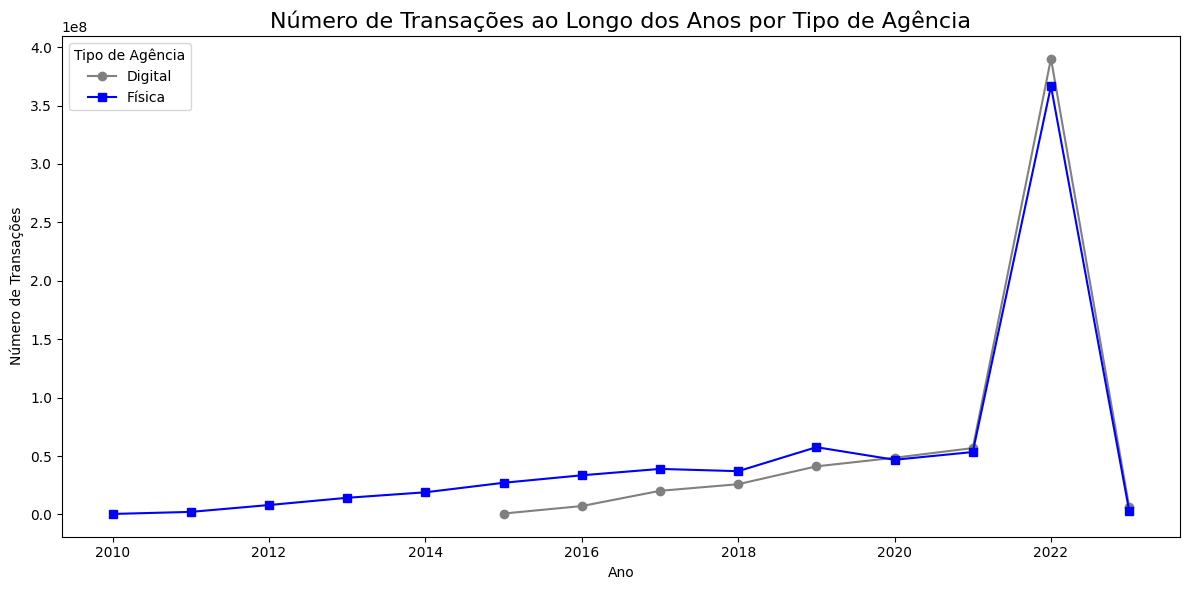

In [ ]:
# @title Gráfico: Transações por tipo de agência
# Agrupando por ano e tipo de agência, contando o número de transações
transacoes_por_tipo_agencia = fact_transacoes.groupby([fact_transacoes['data_transacao'].dt.year, 'tipo_agencia'])['cod_transacao'].sum().unstack()

# Plotando o gráfico de linha
plt.figure(figsize=(12, 6))

# Definindo cores e estilos
colors = ['gray', 'blue']
markers = ['o', 's']


for i, col in enumerate(transacoes_por_tipo_agencia.columns):
    plt.plot(transacoes_por_tipo_agencia.index, transacoes_por_tipo_agencia[col], marker=markers[i], linestyle='-', color=colors[i], label=col.capitalize())



plt.title('Número de Transações ao Longo dos Anos por Tipo de Agência', fontsize=16)
plt.xlabel('Ano')
plt.ylabel('Número de Transações')
plt.legend(title='Tipo de Agência')
plt.grid(False)  # Remover as grades
plt.tight_layout()
plt.show()

### Clientes inativos

Para definir quando um cliente é considerado como tendo churned (inativo), precisamos determinar um período de inatividade após o qual o cliente é considerado como tendo abandonado o banco. No setor bancário, esse período pode variar, mas geralmente um cliente é considerado como tendo churned se não realiza nenhuma transação por um período prolongado.


Vamos assumir que, se um cliente não realizar nenhuma transação por 6 meses consecutivos, ele será considerado como tendo churned.

Próximos passos:

- Para cada cliente, determinamos a data da última transação realizada.   

- Calculamos o tempo decorrido desde a última transação até a data atual.
Definir Churn:

Se o tempo de inatividade exceder 6 meses (ou o período definido), o cliente é considerado como tendo churned.

Esse estudo é importante para tomarmos ações de maneira proativa com esses clientes, influenciando sua volta para o banco.

In [ ]:
# Obter a máxima data de data_ultimo_lancamento
max_data_ultimo_lancamento = dim_contas['data_ultimo_lancamento'].max()

# Por questões mais didáticas, definir a data atual como 1 mês após a máxima data de data_ultimo_lancamento
data_atual = pd.to_datetime(max_data_ultimo_lancamento) + pd.DateOffset(months=1)

# Definição de churn: clientes sem transações nos últimos 6 meses
churn_period = 6
data_limite_churn = data_atual - pd.DateOffset(months=churn_period)

# Identificar clientes churn usando data_ultimo_lancamento de dim_contas
dim_contas['data_ultimo_lancamento'] = pd.to_datetime(dim_contas['data_ultimo_lancamento'])
clientes_churn = dim_contas[dim_contas['data_ultimo_lancamento'] < data_limite_churn]

# Adicionar coluna de churn em dim_clientes
dim_clientes['is_churn'] = dim_clientes['cod_cliente'].isin(clientes_churn['cod_cliente'])

# Filtrar apenas os últimos 12 meses
um_ano_antes = data_atual - pd.DateOffset(months=12)
clientes_churn_ultimo_ano = clientes_churn[clientes_churn['data_ultimo_lancamento'] >= um_ano_antes]

# Contar o número de clientes churn por mês
clientes_churn_por_mes = clientes_churn_ultimo_ano['data_ultimo_lancamento'].dt.to_period('M').value_counts().reset_index()
clientes_churn_por_mes.columns = ['data_transacao', 'num_churn']
clientes_churn_por_mes['data_transacao'] = clientes_churn_por_mes['data_transacao'].astype(str)  # Converter período para string

# Ordenar por mês
clientes_churn_por_mes = clientes_churn_por_mes.sort_values(by='data_transacao')

# Formatando a tabela para exibição
tabela_churn = tabulate(clientes_churn_por_mes, headers=['Mês', 'Número de Clientes Churn'], tablefmt='fancy_grid')

print(tabela_churn)


╒════╤═════════╤════════════════════════════╕
│    │ Mês     │   Número de Clientes Churn │
╞════╪═════════╪════════════════════════════╡
│  6 │ 2022-02 │                          3 │
├────┼─────────┼────────────────────────────┤
│  5 │ 2022-03 │                          3 │
├────┼─────────┼────────────────────────────┤
│  4 │ 2022-04 │                          6 │
├────┼─────────┼────────────────────────────┤
│  1 │ 2022-05 │                         11 │
├────┼─────────┼────────────────────────────┤
│  0 │ 2022-06 │                         13 │
├────┼─────────┼────────────────────────────┤
│  2 │ 2022-07 │                         10 │
├────┼─────────┼────────────────────────────┤
│  3 │ 2022-08 │                          6 │
╘════╧═════════╧════════════════════════════╛


# Dashboard

# Considerações Finais

Implementamos a lógica em Python usando pandas para identificar clientes inativos e realizar uma análise mais detalhada, permitindo ao Banco Vitória tomar ações proativas para reduzir o churn e melhorar a retenção de clientes de forma imediata.